<a href="https://colab.research.google.com/github/fboldt/aulas-am-bsi/blob/main/aula13a_kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [94]:
from sklearn.datasets import load_iris
dataset = load_iris()
X = dataset.data[:,2:]
y = dataset.target

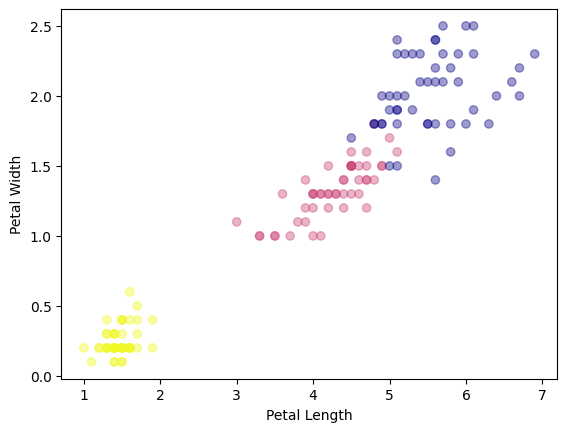

In [95]:
import matplotlib.pyplot as plt
plt.scatter(X[:,0],X[:,1],c=y,alpha=0.4,cmap='plasma_r')
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.show()

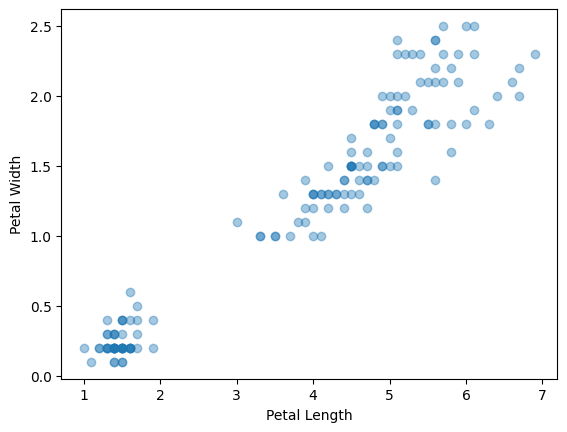

In [96]:
plt.scatter(X[:,0],X[:,1],alpha=0.4)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.show()

[[4.29259259 1.35925926]
 [5.62608696 2.04782609]
 [1.462      0.246     ]]


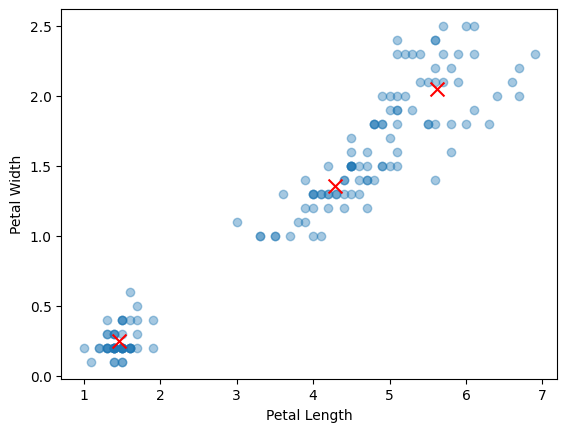

In [97]:
from sklearn.base import BaseEstimator, ClusterMixin, TransformerMixin
import numpy as np


class KMeans(BaseEstimator, ClusterMixin, TransformerMixin):
    def __init__(self, n_clusters=3, max_iter=100):
        self.n_clusters = n_clusters
        self.max_iter = max_iter

    def fit(self, X, y=None):
        self.centroids_ = X[np.random.choice(X.shape[0], self.n_clusters)]
        self.previous_centroids_ = [self.centroids_.copy()]
        while self.max_iter > 0:
            self.max_iter -= 1
            ypred = self.predict(X)
            for i in range(self.n_clusters):
                self.centroids_[i] = X[ypred==i].mean(axis=0)
            if np.allclose(self.centroids_, self.previous_centroids_[-1]):
                break
            self.previous_centroids_.append(self.centroids_.copy())
        self.centroids_ = np.array(self.centroids_)
        return self

    def distances(self, x):
        diferences = self.centroids_ - x
        squared = diferences ** 2
        summed = squared.sum(axis=1)
        root = np.sqrt(summed)
        return root

    def predict(self, X):
        ypred = np.empty(X.shape[0])
        for i, x in enumerate(X):
            distances = self.distances(x)
            centroid = np.argmin(distances)
            ypred[i] = centroid
        return ypred

kmeans = KMeans(n_clusters=3, max_iter=100)
kmeans.fit(X)
print(kmeans.centroids_)

plt.scatter(X[:,0],X[:,1],alpha=0.4)
plt.scatter(kmeans.centroids_[:,0],
            kmeans.centroids_[:,1],
            marker='x', color='r', s=100)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.show()

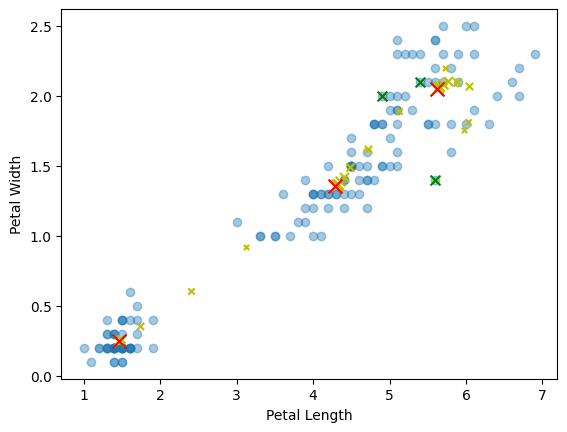

In [98]:
kmeans.fit(X)

plt.scatter(X[:,0],X[:,1],alpha=0.4)
for i in range(len(kmeans.previous_centroids_)):
    plt.scatter(kmeans.previous_centroids_[i][:,0],
                kmeans.previous_centroids_[i][:,1],
                marker='x', color='y', s=7*(i+1))
plt.scatter(kmeans.previous_centroids_[0][:,0],
            kmeans.previous_centroids_[0][:,1],
            marker='x', color='g', s=50)
plt.scatter(kmeans.centroids_[:,0],
            kmeans.centroids_[:,1],
            marker='x', color='r', s=100)
plt.xlabel('Petal Length')
plt.ylabel('Petal Width')
plt.show()

In [99]:
from sklearn.cluster import KMeans

kmeans_k3 = KMeans(n_clusters=3).fit(X)
kmeans_k8 = KMeans(n_clusters=8).fit(X)
print(kmeans_k3.inertia_)
print(kmeans_k8.inertia_)

31.371358974358966
8.183597420127475


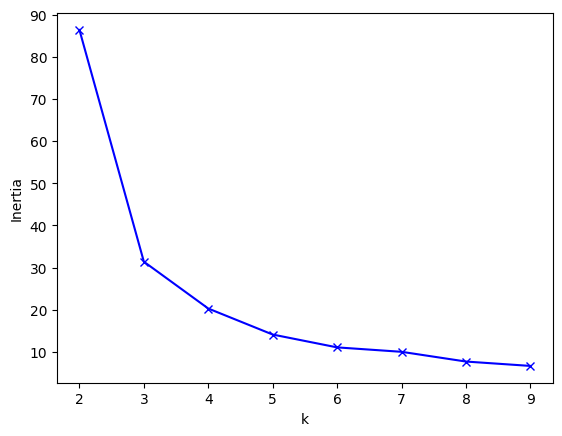

In [100]:
def plot_inertia(X, max_k=10):
  kmeans_per_k = [KMeans(n_clusters=k).fit(X) for k in range(2,max_k)]
  inertias = [model.inertia_ for model in kmeans_per_k]
  plt.plot(range(2,max_k), inertias, 'bx-')
  plt.xlabel('k')
  plt.ylabel('Inertia')
  plt.show()

plot_inertia(X)

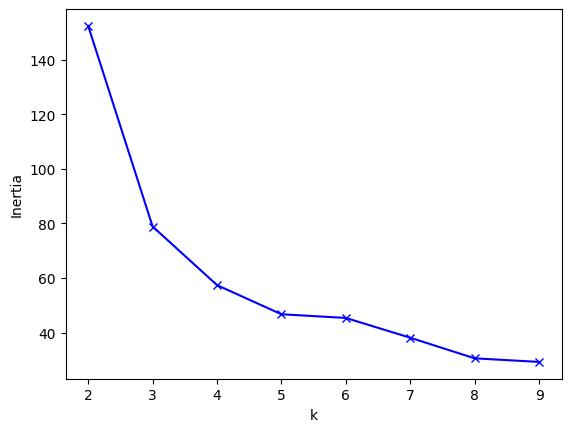

In [101]:
X = dataset.data
plot_inertia(X)

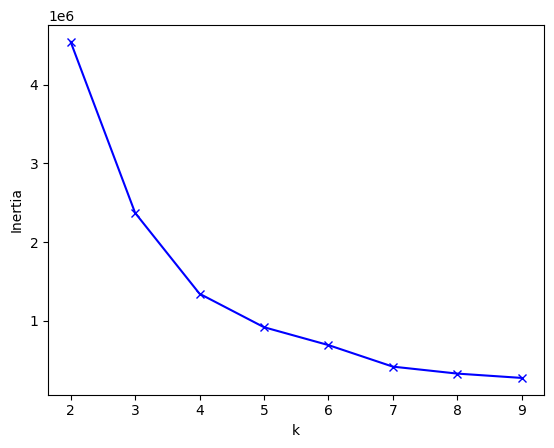

In [102]:
from sklearn.datasets import load_wine
dataset = load_wine()
X = dataset.data
plot_inertia(X)

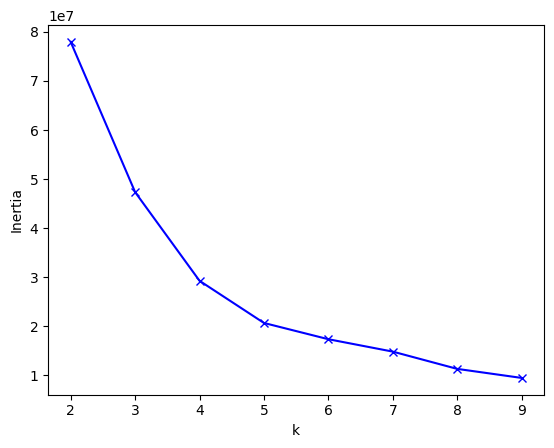

In [103]:
from sklearn.datasets import load_breast_cancer
dataset = load_breast_cancer()
X = dataset.data
plot_inertia(X)

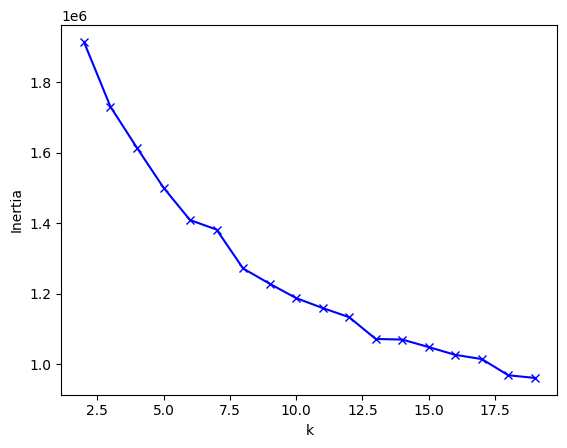

In [104]:
from sklearn.datasets import load_digits
dataset = load_digits()
X = dataset.data
plot_inertia(X, max_k=20)

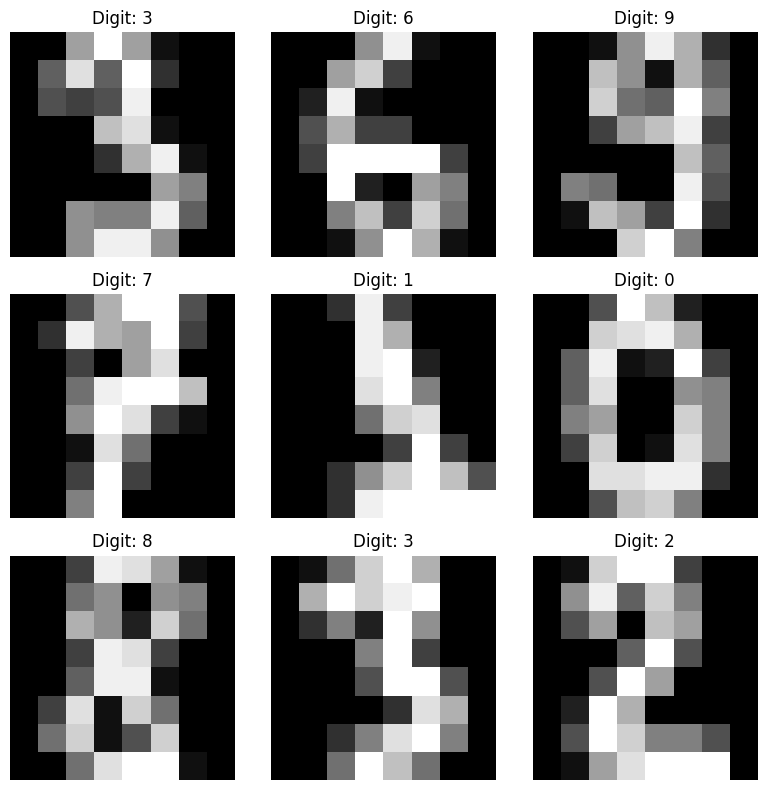

In [105]:
import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(3, 3, figsize=(8, 8))
for i, ax in enumerate(axes.flat):
    random_index = np.random.randint(0, len(X))
    ax.imshow(X[random_index].reshape(8, 8), cmap='gray')
    ax.set_title(f'Digit: {dataset.target[random_index]}')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [106]:
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import cross_validate

scores = cross_validate(RidgeClassifier(), X, dataset.target)
print(scores['test_score'].mean())

0.8881522748375115


In [107]:
from sklearn.pipeline import make_pipeline

model = make_pipeline(KMeans(n_clusters=8), RidgeClassifier())
scores = cross_validate(model, X, dataset.target)
print(scores['test_score'].mean())

0.7523444753946147


In [108]:
model = make_pipeline(KMeans(n_clusters=32), RidgeClassifier())
scores = cross_validate(model, X, dataset.target)
print(scores['test_score'].mean())

0.917643144537295


In [109]:
model = make_pipeline(KMeans(n_clusters=64), RidgeClassifier())
scores = cross_validate(model, X, dataset.target)
print(scores['test_score'].mean())

0.9449210770659239


In [110]:
!pip install optuna -qq

In [111]:
import optuna

def objective(trial):
    n_clusters = trial.suggest_int('n_clusters', 2, 256)
    model = make_pipeline(KMeans(n_clusters=n_clusters), RidgeClassifier())
    scores = cross_validate(model, X, dataset.target)
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=10)
print(study.best_params, "\n", study.best_value)

[I 2025-10-10 13:44:53,915] A new study created in memory with name: no-name-6905af15-e424-4ce4-a5f6-486eac553087
[I 2025-10-10 13:44:55,004] Trial 0 finished with value: 0.9527019498607242 and parameters: {'n_clusters': 91}. Best is trial 0 with value: 0.9527019498607242.
[I 2025-10-10 13:44:56,248] Trial 1 finished with value: 0.9532729805013928 and parameters: {'n_clusters': 100}. Best is trial 1 with value: 0.9532729805013928.
[I 2025-10-10 13:45:00,298] Trial 2 finished with value: 0.9604982977406376 and parameters: {'n_clusters': 134}. Best is trial 2 with value: 0.9604982977406376.
[I 2025-10-10 13:45:02,787] Trial 3 finished with value: 0.962726709996905 and parameters: {'n_clusters': 171}. Best is trial 3 with value: 0.962726709996905.
[I 2025-10-10 13:45:05,717] Trial 4 finished with value: 0.9599427421850819 and parameters: {'n_clusters': 190}. Best is trial 3 with value: 0.962726709996905.
[I 2025-10-10 13:45:11,738] Trial 5 finished with value: 0.9660708758898172 and param

{'n_clusters': 256} 
 0.9660708758898172


In [112]:
def objective(trial):
    n_clusters = trial.suggest_int('n_clusters', 2, 256)
    algorithm = trial.suggest_categorical('algorithm', ['lloyd', 'elkan'])
    model = make_pipeline(KMeans(n_clusters=n_clusters,
                                 algorithm=algorithm),
                          RidgeClassifier())
    scores = cross_validate(model, X, dataset.target)
    return scores['test_score'].mean()

study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print(study.best_params, "\n", study.best_value)

[I 2025-10-10 13:45:20,327] A new study created in memory with name: no-name-1290ad60-d0af-404d-987a-1f6f107ff3e8
[I 2025-10-10 13:45:22,122] Trial 0 finished with value: 0.96161095636026 and parameters: {'n_clusters': 123, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.96161095636026.
[I 2025-10-10 13:45:25,448] Trial 1 finished with value: 0.9610507582791705 and parameters: {'n_clusters': 130, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.96161095636026.
[I 2025-10-10 13:45:26,540] Trial 2 finished with value: 0.9332404828226555 and parameters: {'n_clusters': 37, 'algorithm': 'elkan'}. Best is trial 0 with value: 0.96161095636026.
[I 2025-10-10 13:45:30,669] Trial 3 finished with value: 0.9649551222531724 and parameters: {'n_clusters': 177, 'algorithm': 'elkan'}. Best is trial 3 with value: 0.9649551222531724.
[I 2025-10-10 13:45:33,560] Trial 4 finished with value: 0.9621788919839058 and parameters: {'n_clusters': 183, 'algorithm': 'elkan'}. Best is trial 3 with value: 

{'n_clusters': 218, 'algorithm': 'lloyd'} 
 0.9705137728257505


In [113]:
from sklearn.ensemble import RandomForestClassifier
model = RandomForestClassifier()
scores = cross_validate(model, X, dataset.target)
print(scores['test_score'].mean())

0.9382497678737233
